In [1]:
import psycopg2

def get_connection():
    try:
        return psycopg2.connect(
            database="bde",
            user="myuser",
            password="password",
            host="127.0.0.1",
            port=5432,
        )
    except:
        return False

In [2]:
import pandas as pd
import numpy as np

conn = get_connection()
curr = conn.cursor()
curr.execute("SELECT * FROM vol_by_block;")
by_block_df = pd.DataFrame(curr.fetchall(), columns=['unit','height','value_adj'])

curr = conn.cursor()
curr.execute("SELECT unit FROM vol_all_time order by value_adj DESC limit 10;")
totals_df = pd.DataFrame(curr.fetchall(), columns=['unit'])

# Inner Join to filter down to the top all-time tokens 
# Alternate in SQL; select * from vol_by_block join (select unit from vol_all_time order by value_adj desc limit 5) as ALLTIME on ALLTIME.unit = vol_by_block.unit order by vol_by_block.unit, vol_by_block.height;
top_by_block_df = pd.merge(by_block_df, totals_df['unit'], on=['unit'], how='inner').sort_values(by=['unit','height'])

heights = np.arange(min(top_by_block_df.height),max(top_by_block_df.height) + 1)

# Pad with zeros where there are no values for a particular height
zeros=np.zeros((1, heights.__len__()))
zeros_df=pd.DataFrame({'height': heights, 'value_adj': zeros.tolist()[0]}).set_index('height')
values_by_unit_df=(top_by_block_df
            .groupby('unit')[['height','value_adj']]
            .apply(lambda x: x.set_index('height').combine_first(zeros_df))) ##.reset_index() .fillna('unit')

# Merge Cummulative Moving Average (CMA) data into df; after merge, value_adj_x contains the unsmoothed data, _y contains smoothed data
cma_df = (values_by_unit_df.reset_index().set_index('height')
            .groupby('unit')['value_adj']
            .expanding()
            .mean())

values_cma_df=values_by_unit_df.merge(cma_df, on=["unit","height"], how="left").fillna(0)

# Compute proprtions by unit for each block. Stylistic choice to show a proportional stack area chart
chart_values_dict = values_cma_df.groupby('unit')['value_adj_y'].apply(lambda x: x.values).to_dict()
values = np.array(list(chart_values_dict.values()))
values_sum = values.sum(axis=0).astype(float)
values_sum[values_sum == 0] = 1
proportional_chart_values = (values / values_sum) * 100

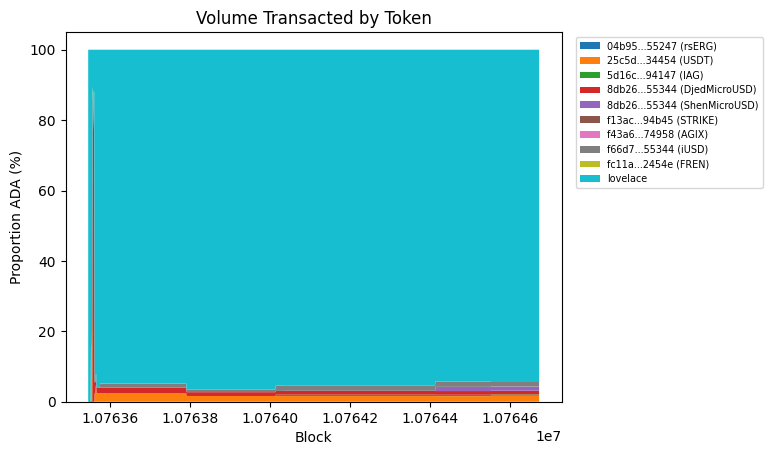

In [4]:
import matplotlib.pyplot as plt

# Decode Asset Name; hex encoded part of the 'unit' & standardise Legend format
labels_=map(lambda x: f'{x[:5]}...{x[x.__len__()-5:]} ({bytes.fromhex(x[56:]).decode('utf-8')})' if x != 'lovelace' else x, list(chart_values_dict.keys()))
plt.stackplot(heights,
              proportional_chart_values, 
              labels=labels_)
 
plt.legend(fontsize='x-small', bbox_to_anchor=(1.02, 1),)
plt.title('Volume Transacted by Token')
plt.xlabel('Block')
plt.ylabel('Proportion ADA (%)')
plt.ticklabel_format(useOffset=False)

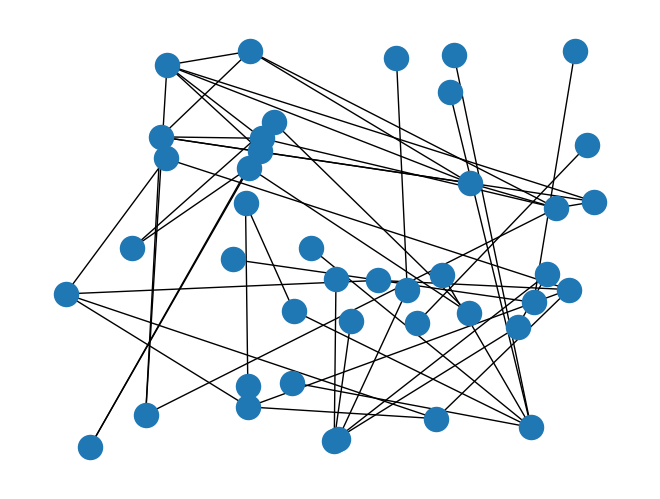

In [8]:
from neo4j import GraphDatabase
import networkx as nx

driver = GraphDatabase.driver("neo4j://127.0.0.1:7687", auth=("neo4j", "mypassword"))
driver.verify_connectivity()
session = driver.session()

# Query all SENT_TO relationships using the following Cypher query
nodes = session.run("MATCH p=()-[r:SENT_TO]->() RETURN p LIMIT 50")
results = [record for record in nodes.data()]

g = nx.Graph()

for res in results:
    sender_addr = res['p'][0].get('address')
    rx_addr = res['p'][2].get('address')
    g.add_edge(sender_addr,rx_addr)
 
nx.draw_random(g, with_labels = False)